# SED CA3 PBCOR_02

In [1]:
import pandas as pd
import matplotlib.pylab as plt

<AxesSubplot:title={'center':'CA3 SED PBCOR_02'}, xlabel='Frequency (GHz)', ylabel='Flux (mJy/beam)'>

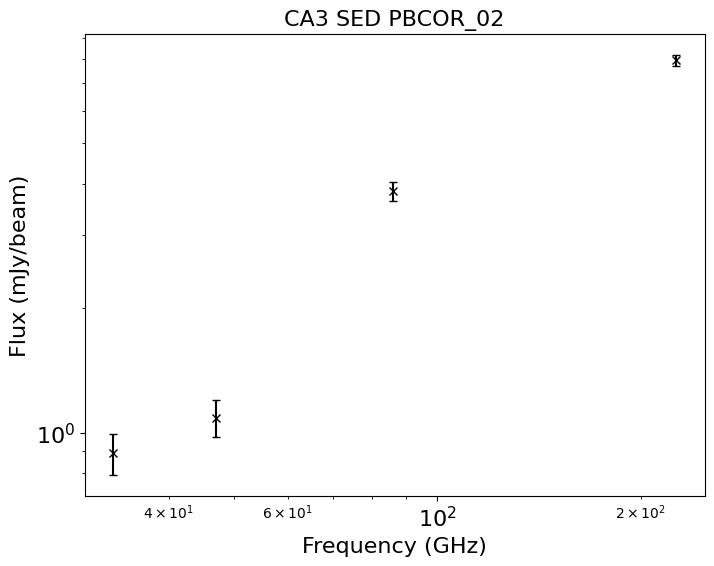

In [24]:
df = pd.read_csv('/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/notebooks/W51CA3_Fitting/hiiregion_W51_CA3_pbcor_03.csv')  

def SED_plot():
    fontsize = 16
    fig, ax = plt.subplots(figsize=(8,6))
    plt.title("CA3 SED PBCOR_02", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel("Frequency (GHz)", fontsize=fontsize)
    ax.set_ylabel("Flux (mJy/beam)", fontsize=fontsize)
    ax.errorbar(df.mu_GHz, df.amp_mJy, yerr=df.amp_error_mJy, fmt='x', color="black", capsize=3)
    ax.loglog()
    return ax

SED_plot()

In [4]:
import numpy as np
from scipy.constants import c

In [25]:
c1 = 0.0446511627906
c2 = 0.00054421768707
c3 = 6.478781989e-6
c4 = 7.712835701e-8
mu1 = np.linspace(30,250,100)
amp1 = c1*(mu1**1)
amp2 = c2*(mu1**2)
amp3 = c3*(mu1**3)
amp4 = c4*(mu1**4)

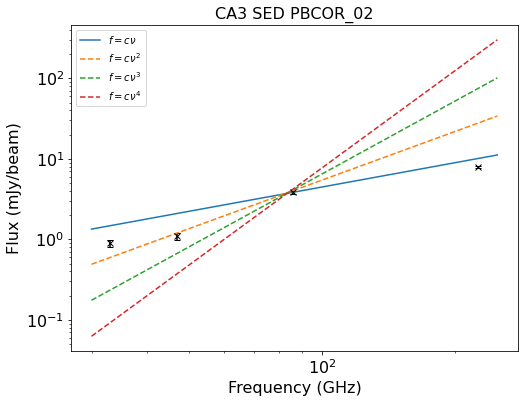

In [8]:
ax = SED_plot()
plt.loglog(mu1, amp1, label='$f =c\\nu$')
plt.loglog(mu1, amp2, label='$f =c\\nu^2$', linestyle = '--')
plt.loglog(mu1, amp3, label='$f =c\\nu^3$', linestyle = '--')
plt.loglog(mu1, amp4, label='$f =c\\nu^4$', linestyle = '--')
plt.loglog()

plt.legend()

In [9]:
%matplotlib inline
import pylab as pl
from astropy import units as u
from astropy import constants
import radio_beam
import pylab as pl
from dust_emissivity import dust
import numpy as np
#from constants import frequency as cfreq, distance


from astropy.visualization import quantity_support
quantity_support()  
pl.matplotlib.style.use('default')

cfreq = 100*u.GHz
distance = 8.1*u.kpc

def dens(Qlyc=1e45*u.s**-1, R=0.1*u.pc, alpha_b=2e-13*u.cm**3*u.s**-1):
    return (((3 * Qlyc)/(4 * np.pi * R**3 * alpha_b))**0.5).to(u.cm**-3)

def EMfunc(Qlyc=1e45*u.s**-1, R=0.1*u.pc, alpha_b=2e-13*u.cm**3*u.s**-1):
    return (R * (((3 * Qlyc)/(4 * np.pi * R**3 * alpha_b))**0.5)**2).to(u.cm**-6*u.pc)

def tau(nu, EM, Te=7000*u.K):
    # eq 4.60 of https://www.cv.nrao.edu/~sransom/web/Ch4.html
    return 3.28e-7 * (Te/(1e4*u.K))**-1.35 * (nu/u.GHz)**-2.1 * (EM/(u.cm**-6*u.pc))

def Tb(Te=7000*u.K, nu=cfreq, EM=EMfunc()):
    return Te * (1-np.exp(-tau(nu=nu, EM=EM, Te=Te)))
    #return (8.235e-2 * (Te/(u.K))**-0.35 * (nu/u.GHz)**-2.1 * (EM/u.cm**-6/u.pc)*u.K).to(u.K)

def Tb_beamdiluted(Te=7000*u.K, nu=cfreq, R=0.1*u.pc, Qlyc=1e45*u.s**-1, beam=4000*u.au):
    tb = Tb(Te=Te, nu=nu, EM=EMfunc(R=R, Qlyc=Qlyc))
    if beam < R:
        return tb
    else:
        return (tb * (R/beam)**2).to(u.K)

def Snu_freefree(Te=7000*u.K, nu=cfreq, EM=None, R=0.1*u.pc, Qlyc=1e45*u.s**-1, beam=4000*u.au,
                 angular_beam=0.5*u.arcsec):
    if EM is None:
        tb = Tb(Te=Te, nu=nu, EM=EMfunc(R=R, Qlyc=Qlyc))
    else:
        tb = Tb(Te=Te, nu=nu, EM=EM)
        
    angular_beam = radio_beam.Beam(angular_beam) if angular_beam.unit.is_equivalent(u.arcsec) else angular_beam.to(u.sr)
        
    if beam < R:
        return tb.to(u.mJy, u.brightness_temperature(frequency=nu, beam_area=angular_beam))
    else:
        return (tb * (R/beam)**2).to(u.mJy, u.brightness_temperature(frequency=nu, beam_area=angular_beam))

def gff(nu, Te=1e4*u.K, Zi=1):
    """
    Draine eqn 10.7
    """
    valid_check =  (Zi * (nu/u.GHz) / (Te/(1e4*u.K))**1.5)
    if np.any(valid_check < 0.14):
        raise ValueError("Invalid approximation")
    elif np.any(valid_check > 250):
        # eqn 10.9
        return np.log(np.exp(5.960-3**0.5/np.pi*np.log(Zi*(nu/u.GHz)*(Te/(1e4*u.K))**-1.5)) + np.exp(1))
    return 6.155 * (Zi * (nu/u.GHz))**-0.118 * (Te/(1e4*u.K))**0.177
    
def freefree_draine_coeff(nu, Te=1e4*u.K, Zi=1):
    """
    Draine eqn 10.1, 10.2
    """
    const = 8/3 * (2*np.pi/3)**0.5 * constants.e.esu**6/constants.m_e**2/constants.c**3 * (constants.m_e/(constants.k_B*Te))**0.5
    unit = u.erg/u.s/u.Hz*u.cm**3
    assert np.abs(const.to(unit) - 5.444e-41*unit) < 0.001e-41*unit
    gaunt = gff(nu=nu, Te=Te)
    boltz = np.exp(-constants.h*nu / (constants.k_B*Te))
    temfac = (Te/(1e4*u.K))**-0.5
    # this is multiplied by density squared
    return const.to(unit) * boltz * temfac * u.sr**-1 * Zi**2 * gaunt

assert np.abs(freefree_draine_coeff(1*u.GHz) - 3.35e-40*u.erg*u.cm**3/u.s/u.Hz/u.sr).value < 0.01e-40

def freefree_draine(nu, EM, Te=1e4*u.K):
    coef = freefree_draine_coeff(nu=nu, Te=Te)
    assert coef.unit.is_equivalent(u.cm**3*u.erg/u.Hz/u.s/u.sr)
    return (coef*EM).to(u.erg/u.s/u.cm**2/u.Hz/u.sr)
    
def snu_dust(density=1e4*u.cm**-3, Td=40*u.K, radius=4000*u.au, distance=distance, cfreq=cfreq):
    mass = (density * 2.8 * u.Da * 4/3. * radius**3).to(u.M_sun)
    print(mass)
    beam = radio_beam.Beam((radius/distance).to(u.arcsec,u.dimensionless_angles()))
    flux = dust.snuofmass(nu=cfreq, mass=mass, beamomega=beam, temperature=Td, distance=distance)
    return flux

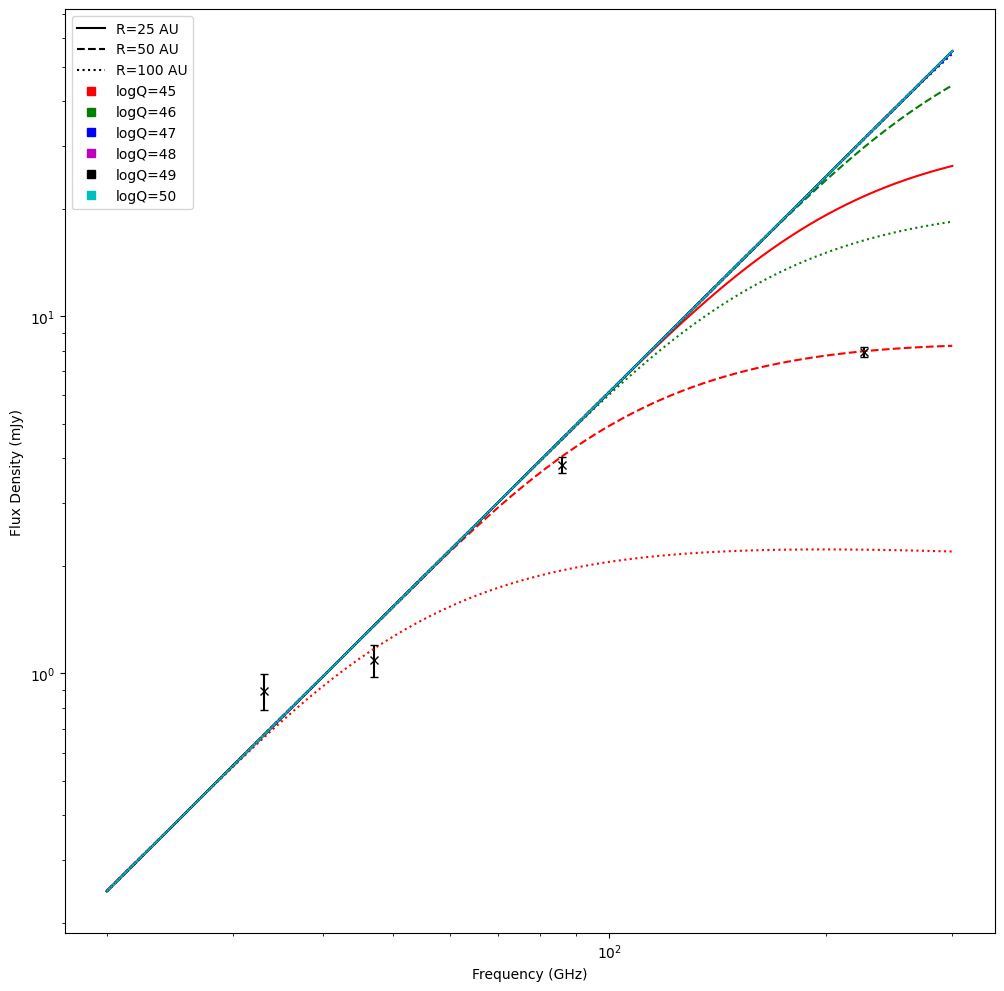

In [47]:


freqs = np.linspace(20,300,1000)*u.GHz


pl.figure(1, figsize=(12,12)).clf()
colors = [x for x in 'rgbmkc']

pl.gca().set_prop_cycle(color=colors)

#pl.figure(2, figsize=(12,12)).clf()
#pl.figure(3, figsize=(12,12)).clf()

radius = 1*u.au
qlycs = np.logspace(45,50,6)*u.s**-1
for radius, linestyle in zip((25,50,100,)*u.au, ('-','--',':','-.')):

    seds_K = [Tb(Te=3000*u.K, nu=freqs, EM=EMfunc(R=radius, Qlyc=qlyc),)
              for qlyc in qlycs]

    seds = [Snu_freefree(Te=300*u.K, nu=freqs, R=radius, Qlyc=qlyc, beam=0.45*u.au,
            angular_beam=0.05*u.arcsec,)
            for qlyc in qlycs]
    taus = [tau(freqs, EMfunc(Qlyc=qlyc, R=radius))
            for qlyc in qlycs]
    labels = ["R={0} Q={1}".format(radius, qlyc) for qlyc in qlycs]

    pl.figure(1)
    lines = pl.loglog(freqs, np.transpose(seds), linestyle=linestyle, label=labels, )
#     pl.figure(2)
#     x = pl.loglog(freqs, np.transpose(taus), linestyle=linestyle, label=labels, )
#     pl.figure(3)
#     x = pl.loglog(freqs, np.transpose(seds_K), linestyle=linestyle, label=labels, )
pl.figure(1)
pl.errorbar(df.mu_GHz, df.amp_mJy, yerr=df.amp_error_mJy, fmt='x', color="black", capsize=3)
pl.xlabel("Frequency (GHz)")
pl.ylabel("Flux Density (mJy)")
pl.legend((pl.Line2D([0],[0],linestyle='-', color='k'),
           pl.Line2D([0],[0],linestyle='--', color='k'),
           pl.Line2D([0],[0],linestyle=':', color='k'),)
          + tuple(pl.Line2D([0],[0],marker='s',linestyle='none', color=colors[ii])
                  for ii in range(len(qlycs)))
          ,
          ('R=25 AU','R=50 AU','R=100 AU',) + tuple("logQ={0}".format(int(np.log10(qlyc.value))) for qlyc in qlycs)
          ,
         )